# Ridge Regression

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


In [4]:
columb["home_value"] = columb["home.value"]

## Model Definition

In [5]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=jnp.asarray(df.crime),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [6]:
loc += tb.slin("scale(area)*scale(income) + home_value")
loc += tb.slin("x")

### Build and plot model

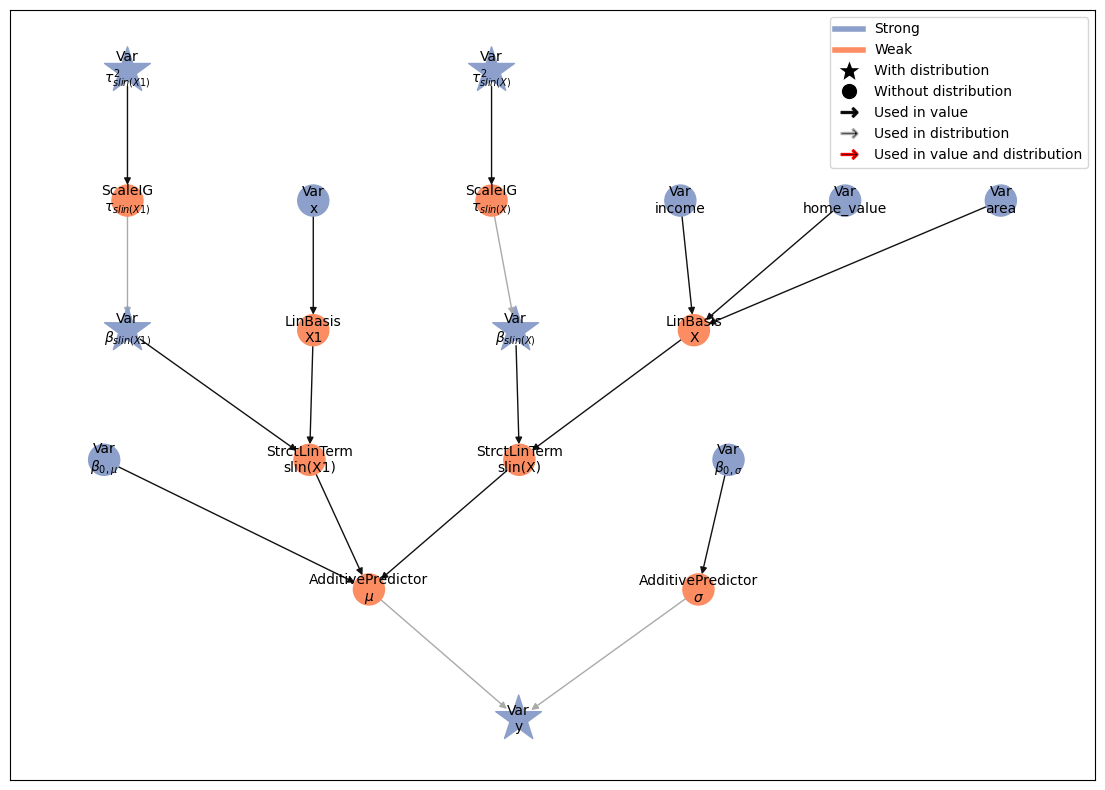

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{slin(X1)}$', '$\\tau_{slin(X1)}^2$', '$\\beta_{slin(X)}$', '$\\tau_{slin(X)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:05<00:00,  1.94s/chunk]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:01<00:00,  8.41chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                              kernel       mean         sd     q_0.05  \
parameter           index                                               
$\beta_{0,\mu}$     ()     kernel_01  50.423874   5.551556  41.285841   
$\beta_{0,\sigma}$  ()     kernel_00   2.568712   0.135054   2.341922   
$\beta_{slin(X)}$   (0,)   kernel_04  -0.747856   1.243803  -3.372592   
                    (1,)   kernel_04  -2.408074   3.028234  -8.593204   
                    (2,)   kernel_04  -0.404911   0.128513  -0.611758   
                    (3,)   kernel_04   0.352666   1.088577  -1.006980   
$\beta_{slin(X1)}$  (0,)   kernel_02   0.011789   0.148353  -0.186421   
$\tau_{slin(X)}^2$  ()     kernel_05   4.572954  10.528326   0.022895   
$\tau_{slin(X1)}^2$ ()     kernel_03   0.026659   0.140826   0.001746   

                               q_0.5     q_0.95  sample_size     ess_bulk  \
parameter           index                                                   
$\beta_{0,\mu}$     ()     50.548395  59.528074         4000   744.300102   
$\beta_{0,\sigma}$  ()      2.573146   2.786142         4000   762.876288   
$\beta_{slin(X)}$   (0,)   -0.300267   0.512158         4000  1192.404522   
                    (1,)   -0.707601   0.222592         4000   526.360584   
                    (2,)   -0.408155  -0.191760         4000   736.870889   
                    (3,)    0.098186   2.637049         4000  2141.832670   
$\beta_{slin(X1)}$  (0,)    0.006168   0.220925         4000  3153.910219   
$\tau_{slin(X)}^2$  ()      0.374988  21.814411         4000   463.782228   
$\tau_{slin(X1)}^2$ ()      0.007448   0.089177         4000  3585.686105   

                              ess_tail      rhat  
parameter           index                         
$\beta_{0,\mu}$     ()     1364.879959  1.005233  
$\beta_{0,\sigma}$  ()     2102.167502  1.003906  
$\beta_{slin(X)}$   (0,)   2251.706487  1.003214  
                    (1,)   1451.542407  1.002918  
                    (2,)   1501.586357  1.004544  
                    (3,)   2199.561835  1.002726  
$\beta_{slin(X1)}$  (0,)   2807.517916  1.001177  
$\tau_{slin(X)}^2$  ()     1585.615221  1.006425  
$\tau_{slin(X1)}^2$ ()     3392.821623  1.000141

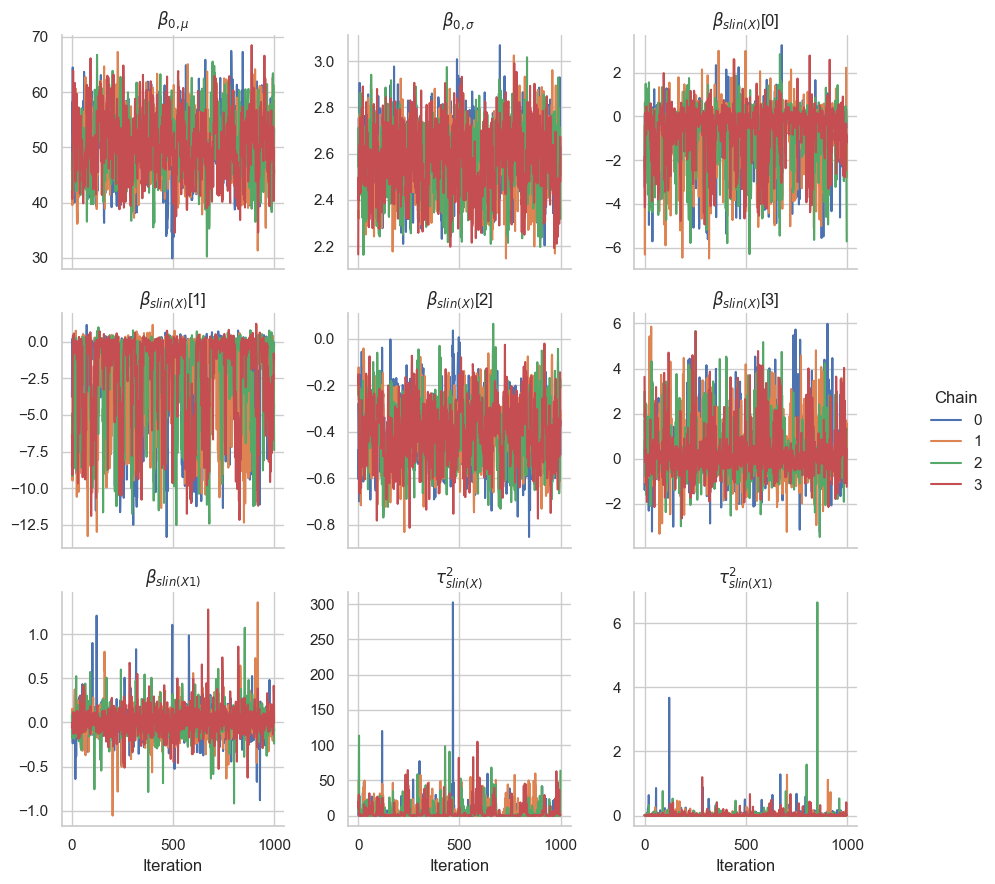

In [10]:
gs.plot_trace(results)

In [11]:
samples = results.get_posterior_samples()

In [12]:
gam.summarise_lin(model.vars["slin(X)"], samples)

,x,sample_size,mean,var,sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
0,scale(area),4000,-0.747856,1.547045,1.243803,-3.372592,-0.300267,0.512158,-2.927002,0.739477
1,scale(income),4000,-2.408074,9.170200,3.028234,-8.593204,-0.707601,0.222592,-7.445577,0.507699
2,home_value,4000,-0.404911,0.016516,0.128513,-0.611758,-0.408155,-0.191760,-0.617899,-0.201955
3,scale(area):scale(income),4000,0.352666,1.185000,1.088577,-1.006980,0.098186,2.637049,-1.092426,2.469852


In [13]:
gam.summarise_lin(model.vars["slin(X1)"], samples)

,x,sample_size,mean,var,sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
0,x,4000,0.011789,0.022009,0.148353,-0.186421,0.006168,0.220925,-0.19329,0.206631


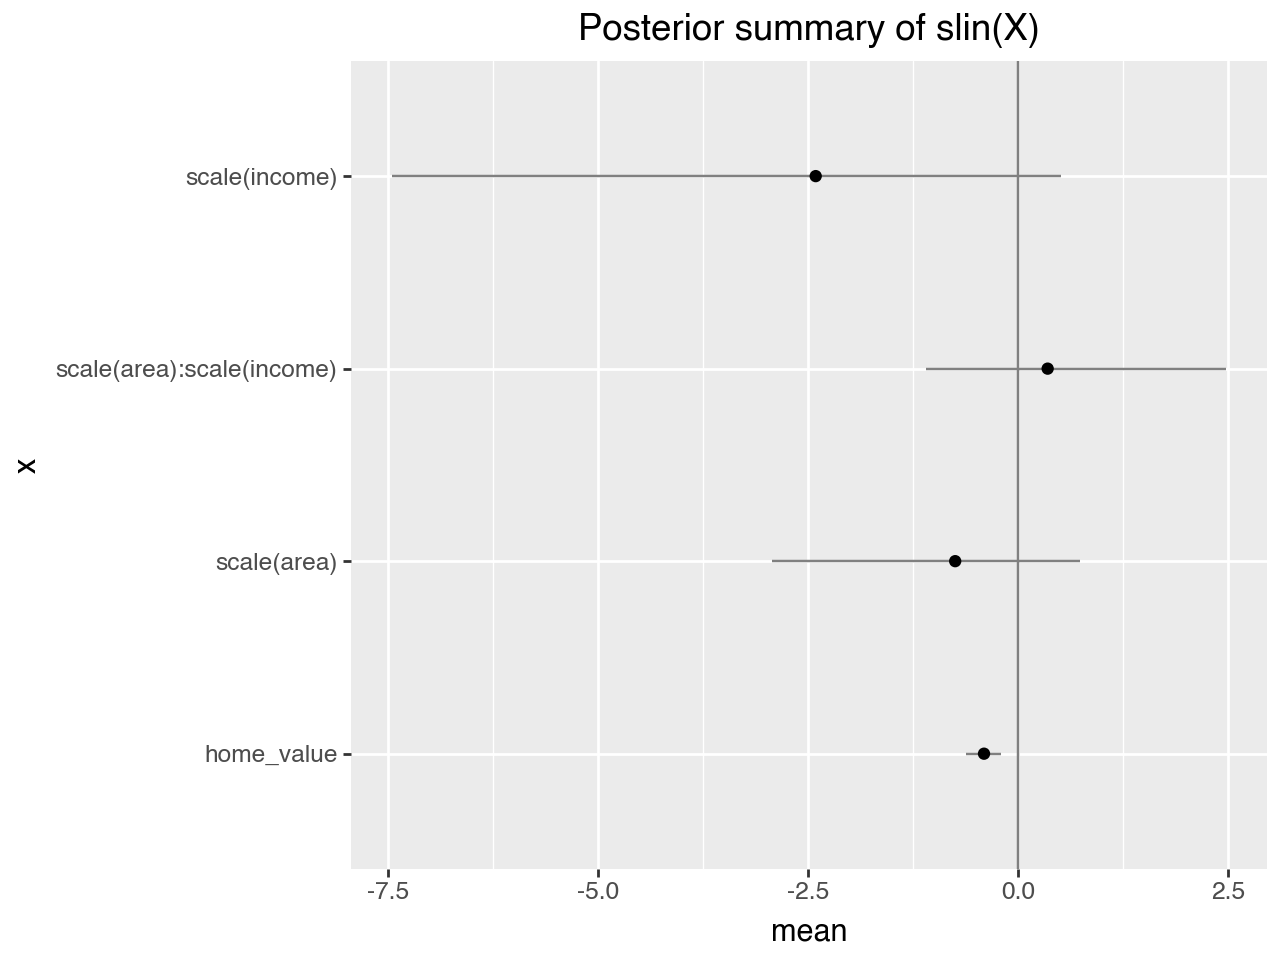

In [14]:
term = model.vars["slin(X)"]
gam.plot_forest(term, samples)

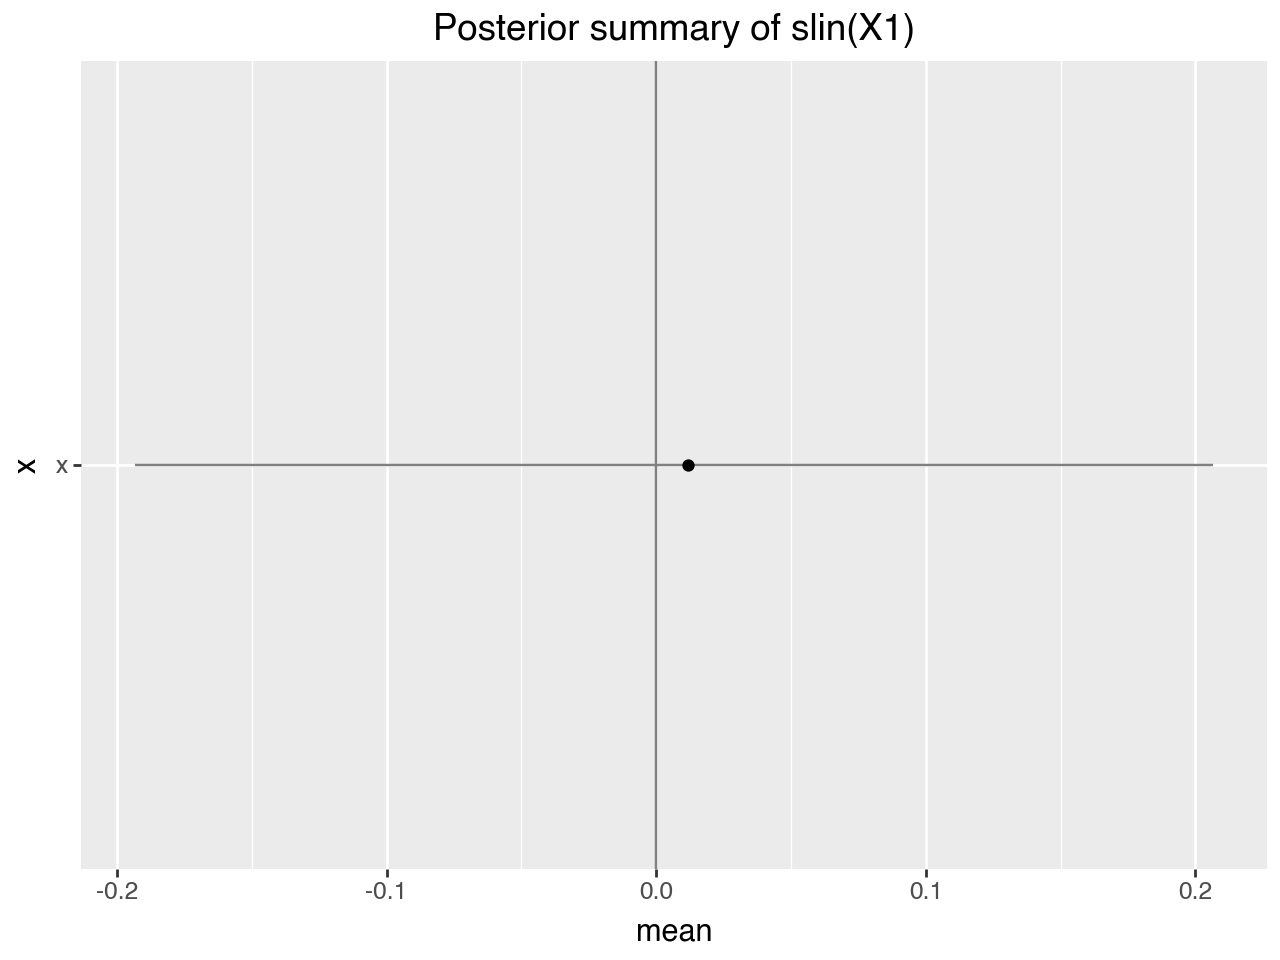

In [15]:
term = model.vars["slin(X1)"]
gam.plot_forest(term, samples)